# Making chloropleth maps in Altair

Here's a quick example of how to make a chloropleth map in Altair.  In this example, we'll work with a fairly large data set of baby names in France from 1900-2019, broken down by department.

To work with geographical data, we'll use the `geopandas`, which loads `pandas` dataframes, but with support for geographical outlines in the `geojson` format.  You can use these dataframes just as you would a regular `pandas` dataframe, but they will include that extra geographical outline data.

To get started, we'll need to import our libraries.

In [103]:
import altair as alt
import pandas as pd
import geopandas as gpd # Requires geopandas -- e.g.: conda install -c conda-forge geopandas
alt.data_transformers.enable('json') # Let Altair/Vega-Lite work with large data sets

pass

# Reading our names data

Now, let's read in our dataset.  The exported data is in CSV format, but with a `;` separator instead of commas.  The INSEE data collapses rare names or where department-level information has been elided (presumably to protect individuals with uncommon names or who were one of the only ones born with that name in a given year).  We'll strip those out.

In [104]:
names = pd.read_csv("dpt2020.csv", sep=";")
names.drop(names[names.preusuel == '_PRENOMS_RARES'].index, inplace=True)
names.drop(names[names.dpt == 'XX'].index, inplace=True)

names.sample(5)

,sexe,preusuel,annais,dpt,nombre
512527,1,FAHD,2010,75,4
2097267,2,CÉCILIA,2002,21,4
1016481,1,LOICK,1995,68,4
2005165,2,BÉATRICE,1978,31,15
3619726,2,SYLVIE,1956,46,18


# Loading map data

Next, let's load some map data of regions in France using `geopandas`.  These map data come from the [INSEE] and [IGN] and were processed into the `geojson` format we'll need to work with by [Grégoire David].  Here's the [github] repository.

In this example, we'll work with the simplified departments tiles for the Hexagon, but that repository contains higher-resolution versions, the DOM-TOM, and more.

[Grégoire David]: https://gregoiredavid.fr
[INSEE]: http://www.insee.fr/fr/methodes/nomenclatures/cog/telechargement.asp
[IGN]: https://geoservices.ign.fr/adminexpress
[github]: https://github.com/gregoiredavid/france-geojson/

In [105]:
depts = gpd.read_file('departements-version-simplifiee.geojson')

depts.sample(5)

,code,nom,geometry
75,75,Paris,"POLYGON ((2.41634 48.84924, 2.46226 48.84254, ..."
71,71,Saône-et-Loire,"POLYGON ((4.11597 47.12334, 4.15377 47.11456, ..."
86,86,Vienne,"POLYGON ((-0.10212 47.06480, -0.09806 47.09135..."
65,65,Hautes-Pyrénées,"MULTIPOLYGON (((-0.10308 43.24282, -0.12194 43..."
79,79,Deux-Sèvres,"POLYGON ((-0.89196 46.97582, -0.85592 46.97908..."


Notice how `depts` is a geopandas dataframe.  We'll use it just as a regular `pandas` dataframe, but it includes the geometry info we need to be able to draw those regions when we pass them into Altair.  We just need to make sure that when we work with our data, we keep them in a geopandas dataframe and not a plain dataframe if we want to draw the departments.

In the next cell, notice how we do a right-merge to bring in department data into names.  We do this as a merge on `depts` because we need a geopandas dataframe.  Remember, `depts` is a geopandas dataframe, while `names` is a regular dataframe.  If we did a left merge on `names`, we'd end up with a regular pandas dataframe. After this merge, both `names` and `depts` will be geopandas dataframes.

**Hint:** Be careful when you do your data joins here.  It's easy to accidentally merge the wrong way to accidentally create a _much bigger_ dataset.

In [106]:
# Keep a reference around to the plain pandas dataframe, without geometry data, just in case
just_names = names

names = depts.merge(names, how='right', left_on='code', right_on='dpt')

names.sample(5)

,code,nom,geometry,sexe,preusuel,annais,dpt,nombre
3144889,NaN,NaN,None,2,MELAINE,1987,971,3
3212742,49,Maine-et-Loire,"POLYGON ((-1.24588 47.77672, -1.23825 47.80999...",2,MYLÈNE,1986,49,7
2240492,62,Pas-de-Calais,"POLYGON ((2.06771 51.00651, 2.09760 50.99843, ...",2,DOROTHEE,1992,62,3
3079614,21,Côte-d'Or,"MULTIPOLYGON (((4.18190 47.15051, 4.18711 47.1...",2,MARINA,1981,21,10
1834150,87,Haute-Vienne,"POLYGON ((0.82343 46.12858, 0.83345 46.16655, ...",2,ANGÈLE,1921,87,35


# Show a name over all years

Now we'll choose a name to show across all years.  To that, we'll group all of the names in a department together (squashing the years together) and use the sum.

In [107]:
# Aggregate data, assuming 'nombre' is your count column
grouped = names.groupby(['dpt', 'preusuel', 'sexe'], as_index=False)['nombre'].sum()

# Merge the aggregated data back with the geometry data from 'depts'
# Ensure 'code' in depts matches 'dpt' in grouped
grouped = grouped.merge(depts[['code', 'geometry']], how='left', left_on='dpt', right_on='code')

# Convert back to a GeoDataFrame if needed for geographic operations
grouped = gpd.GeoDataFrame(grouped, geometry='geometry')

grouped

,dpt,preusuel,sexe,nombre,code,geometry
0,01,AARON,1,160,01,"POLYGON ((4.78021 46.17668, 4.79458 46.21832, ..."
1,01,ABBY,2,3,01,"POLYGON ((4.78021 46.17668, 4.79458 46.21832, ..."
2,01,ABDALLAH,1,7,01,"POLYGON ((4.78021 46.17668, 4.79458 46.21832, ..."
3,01,ABDEL,1,3,01,"POLYGON ((4.78021 46.17668, 4.79458 46.21832, ..."
4,01,ABDELKADER,1,3,01,"POLYGON ((4.78021 46.17668, 4.79458 46.21832, ..."
...,...,...,...,...,...,...
239574,974,ÉSAÏE,1,3,NaN,None
239575,974,ÉTHAN,1,53,NaN,None
239576,974,ÉTIENNE,1,3,NaN,None
239577,974,ÉVA,2,32,NaN,None


In [108]:
import pandas as pd

# Normalisation des codes de département
def normalize_department_code(code):
    if code in ['2A', '2B']:
        return '20'
    return code

# Appliquer la normalisation aux deux ensembles de données
depts['code'] = depts['code'].apply(normalize_department_code)
just_names['dpt'] = just_names['dpt'].apply(normalize_department_code)

# Fusion après la normalisation
names = depts.merge(just_names, how='right', left_on='code', right_on='dpt')

In [109]:
# Après la fusion, vérifiez si des lignes ont des valeurs NaN pour la colonne 'nombre'
print(names[names['nombre'].isna()])

Empty GeoDataFrame
Columns: [code, nom, geometry, sexe, preusuel, annais, dpt, nombre]
Index: []


In [110]:
# Vérifier également la correspondance des codes de départements
print(depts['code'].unique())  # Les codes dans les données géographiques
print(just_names['dpt'].unique())  # Les codes dans les données de prénoms

['01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12' '13' '14'
 '15' '16' '17' '18' '19' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '20' '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42'
 '43' '44' '45' '46' '47' '48' '49' '50' '51' '52' '53' '54' '55' '56'
 '57' '58' '59' '60' '61' '62' '63' '64' '65' '66' '67' '68' '69' '70'
 '71' '72' '73' '74' '75' '76' '77' '78' '79' '80' '81' '82' '83' '84'
 '85' '86' '87' '88' '89' '90' '91' '92' '93' '94' '95']
['84' '92' '95' '75' '69' '93' '67' '29' '76' '94' '971' '33' '91' '06'
 '11' '13' '31' '34' '18' '49' '59' '60' '77' '21' '44' '974' '68' '02'
 '03' '08' '12' '14' '25' '35' '42' '54' '57' '58' '61' '62' '66' '78'
 '83' '01' '17' '30' '37' '38' '40' '45' '51' '53' '56' '71' '72' '73'
 '74' '80' '81' '86' '87' '972' '07' '10' '22' '27' '28' '41' '47' '63'
 '64' '65' '85' '89' '16' '24' '36' '39' '79' '88' '04' '19' '20' '26'
 '50' '55' '70' '82' '90' '973' '15' '52' '05' '43' '09' '32' '48' '23'
 '46']


In [111]:
# grouped = names.groupby(['dpt', 'preusuel', 'sexe'], as_index=False).sum()
# grouped = depts.merge(grouped, how='right', left_on='code', right_on='dpt') # Add geometry data back in
# grouped

Now let's pick a name and check out how it's distribution over the last 120 years across Metropolitan France.  In this example, I choose the name “Lucien,” which I rather like for some reason.

In [112]:
name = 'LUCIEN'
subset = grouped[grouped.preusuel == name]

# Ensure tooltip fields are correct
tooltip_fields = ['preusuel', 'code', 'nombre']  # Updated to use correct field names

# Create the chart
alt.Chart(subset).mark_geoshape(stroke='white').encode(
    tooltip=tooltip_fields,
    color='nombre:Q',  # Ensure the data type for color encoding is quantitative
).properties(width=800, height=600)

alt.Chart(...)

### Vizu 3

You need to put a name (preusuel) in the research bar to get the graphic 

for exemple "CAMILLE"

In [129]:
import pandas as pd
import plotly.express as px
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

# Charger les données
df = pd.read_csv('dpt2020.csv', sep=';')

# Supprimer les lignes où 'annais' est 'XXXX'
df = df[df['annais'] != 'XXXX']

df.rename(columns={'annais': 'Années', 'nombre': 'Nombre', 'preusuel': 'Prénom'}, inplace=True)
df['Années'] = df['Années'].astype(int)

# Aggrégation des données
df_aggregated = df.groupby(['Années', 'sexe', 'Prénom']).agg({'Nombre': 'sum'}).reset_index()
df_aggregated['sexe'] = df_aggregated['sexe'].map({1: 'Masculin', 2: 'Féminin'})

# Initialisation de l'application Dash
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Évolution des naissances par prénom"),
    dcc.Input(id='prenom-input', type='text', value='', placeholder='Entrez un prénom'),
    dcc.Graph(id='prenom-graph')
])

@app.callback(
    Output('prenom-graph', 'figure'),
    [Input('prenom-input', 'value')]
)
def update_graph(prenom):
    filtered_df = df_aggregated[df_aggregated['Prénom'].str.upper() == prenom.upper()]
    if filtered_df.empty:
        return px.line(title='Aucune donnée disponible pour ce prénom')
    else:
        fig = px.line(filtered_df, x='Années', y='Nombre', color='sexe',
                      title=f'Évolution des naissances pour le prénom {prenom.capitalize()}')
        return fig

if __name__ == '__main__':
    app.run_server(debug=True)


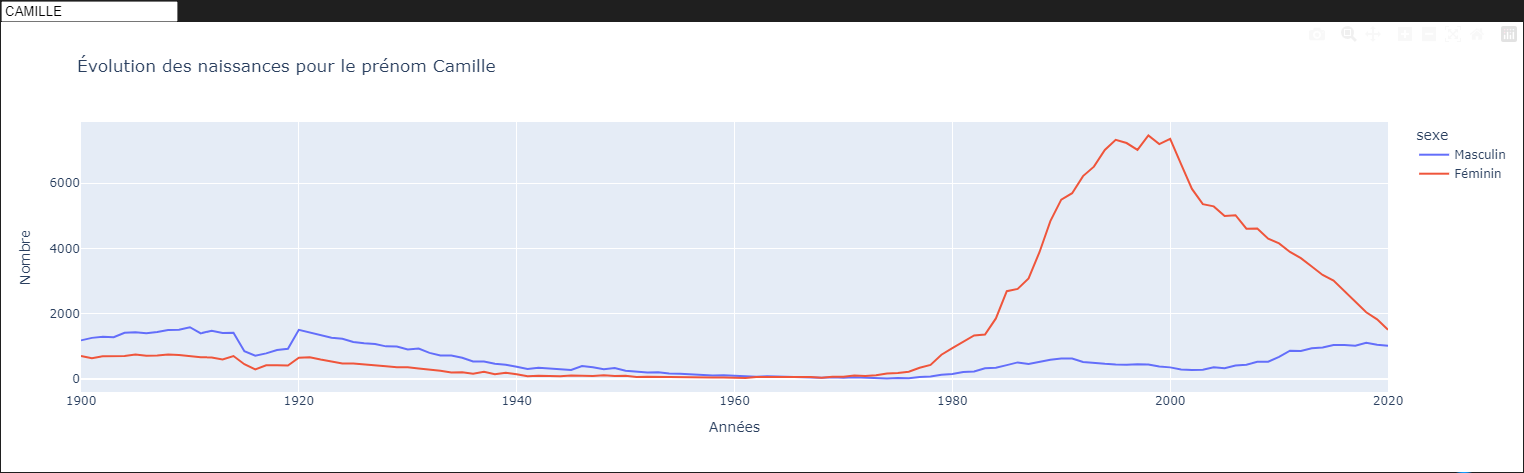

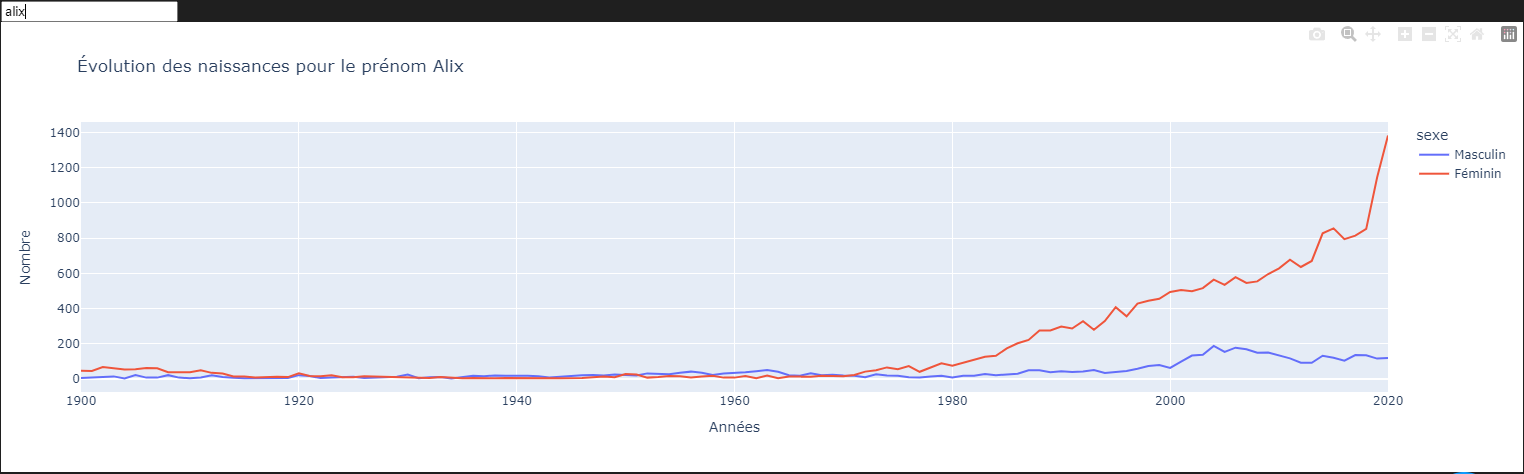

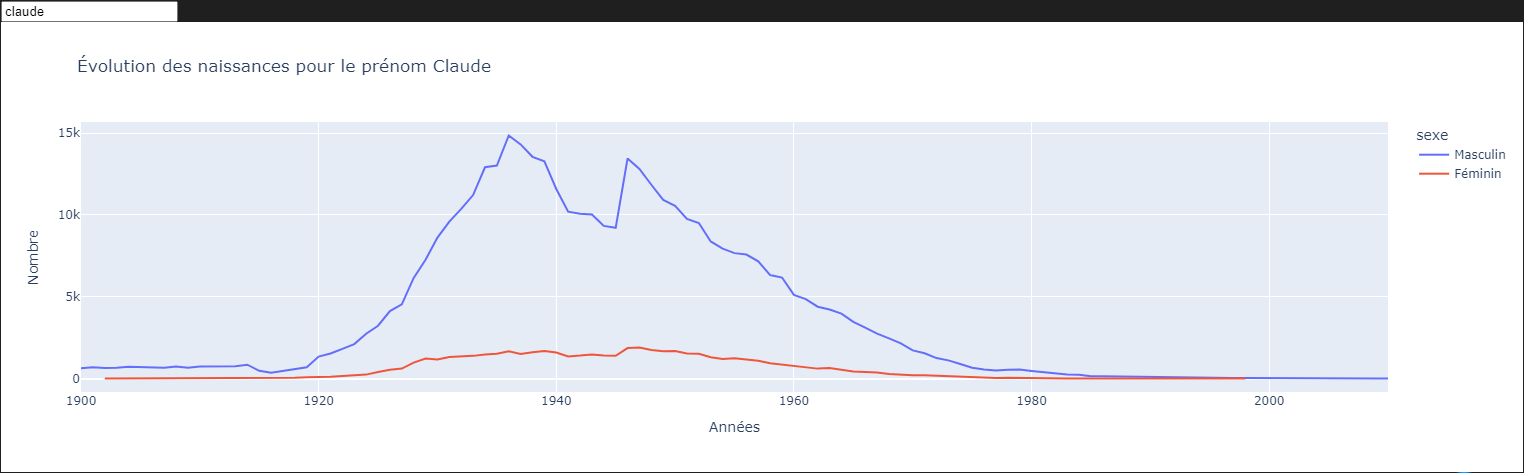